In [1]:
import matplotlib.pyplot as plt
import sys
import wfdb

sys.path.append("../../raccoon")

from annotationutils import trigger_points
from detectors import XiangDetector
from triggerutils import signal_to_points

Using TensorFlow backend.


## Read Records

In [2]:
def read_record(path, sampfrom, sampto):
    record = wfdb.rdrecord(path, sampfrom=sampfrom, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampfrom=sampfrom, sampto=sampto)
    signal = record.p_signal.T[0]
    trigger = [tp-sampfrom for tp in trigger_points(annotation)]
    return signal, trigger

def read_records(directory, names, sampfrom, sampto):
    signals, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        signal, trigger = read_record(path, sampfrom, sampto)
        signals.append(signal)
        triggers.append(trigger)
    return signals, triggers

In [3]:
train_dir = "../../data/mitdb"
train_names = ["100", "101", "102", "103", "104"]

test_dir = "../../data/nstdb"
test_names = ["118e_6", "118e00", "118e06", "118e12", "118e18", "118e24"]
plot_titles = [
    "Record 118 (SNR = -6dB)",
    "Record 118 (SNR = 0dB)",
    "Record 118 (SNR = 6dB)",
    "Record 118 (SNR = 12dB)",
    "Record 118 (SNR = 18dB)",
    "Record 118 (SNR = 24dB)"]

sampfrom = 140000
sampto = 150000

train_signals, train_triggers = read_records(
    train_dir, train_names, sampfrom, sampto)
test_signals, test_triggers = read_records(
    test_dir, test_names, sampfrom, sampto)

## Train

In [4]:
detector = XiangDetector(32, 60, 10, 5)
detector.train(train_signals, train_triggers)

Epoch 1/1
1552/1552 [==============================] - 8s 5ms/step - loss: 0.0571


## Test

In [5]:
trigger_signals = detector.trigger_signals(test_signals)

detected_triggers, certainties = tuple(zip(*[
    signal_to_points(trigger_signal, with_certainty=True)
    for trigger_signal in trigger_signals]))

detected_triggers, certainties = list(detected_triggers), list(certainties)

## Plot

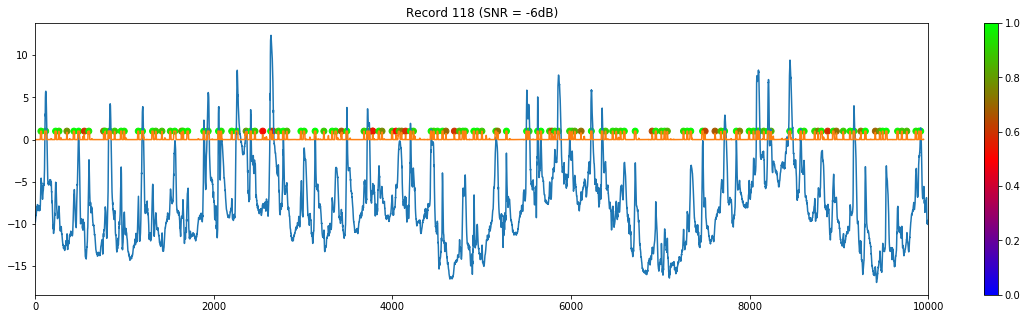

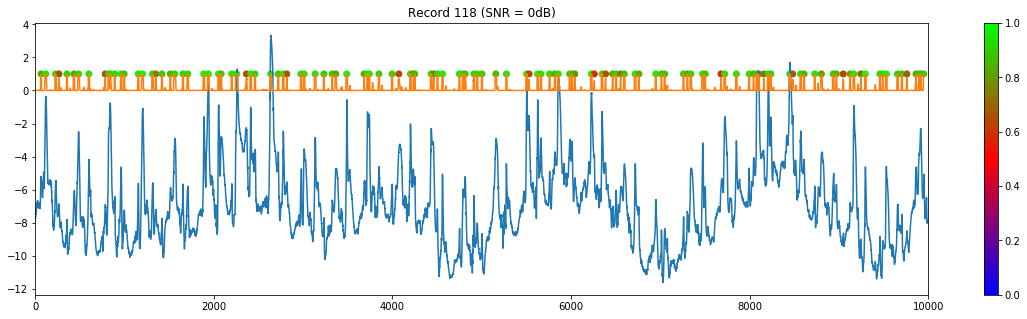

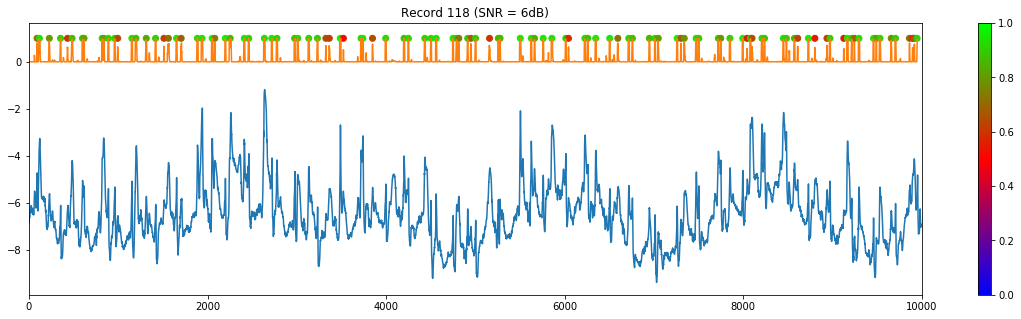

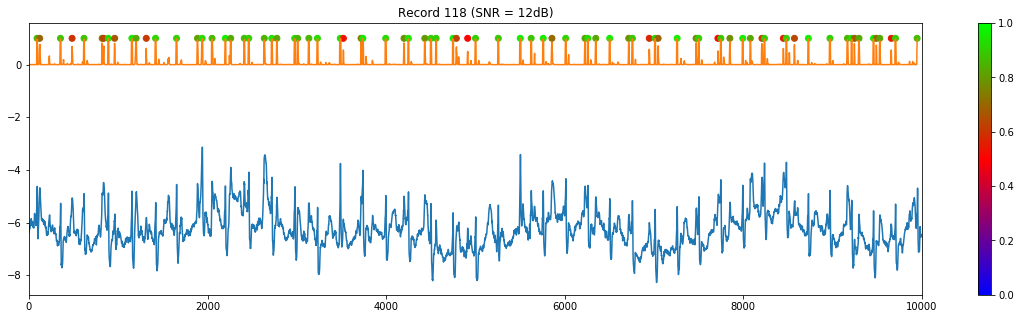

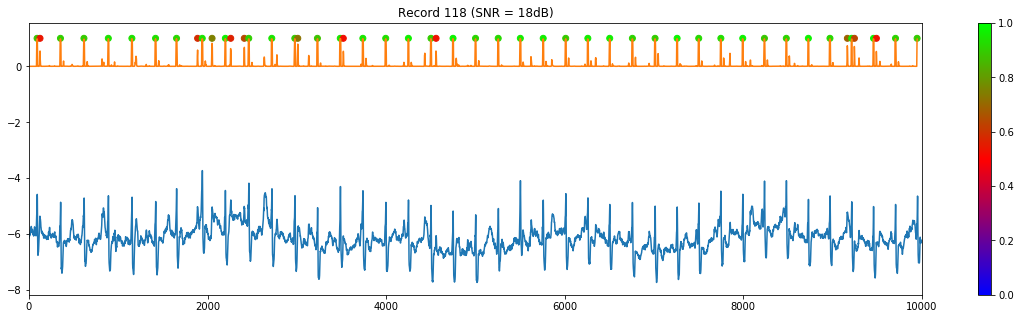

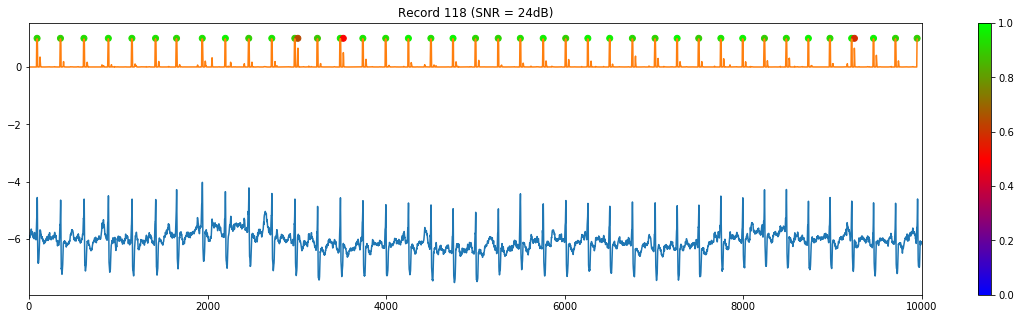

In [7]:
for idx in range(len(test_signals)):
    plt.figure(figsize=(20,5))
    plt.title(plot_titles[idx])
    plt.xlim((0,10000))
    plt.plot(test_signals[idx])
    plt.plot(trigger_signals[idx])
    plt.scatter(
        detected_triggers[idx], [1]*len(detected_triggers[idx]),
        c=certainties[idx], cmap='brg')
    plt.clim(0,1)
    plt.colorbar()
    plt.show()